In [1]:
import torch
import pandas as pd

from transformer_lens import HookedTransformer
import einops

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

torch.set_grad_enabled(False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
model = HookedTransformer.from_pretrained('gelu-4l')
model.cfg.use_attn_result = True
model.to(device);

Loaded pretrained model gelu-4l into HookedTransformer
Moving model to device:  cuda


In [3]:
print("W_in  shape:", model.W_in.shape)
print("W_out shape:", model.W_out.shape)
print("b_in  shape:", model.b_in.shape)

W_in  shape: torch.Size([4, 512, 2048])
W_out shape: torch.Size([4, 2048, 512])
b_in  shape: torch.Size([4, 2048])


In [4]:
# Rearrange, calculate dot products and cosine similarities
W_in = einops.rearrange(model.W_in, 'layer d_model neuron -> layer neuron d_model')
W_out = model.W_out  # (layer, neuron, d_model)

W_in_out_dot_prods = einops.einsum(
    W_in, W_out,
    "layer neuron d_model, layer neuron d_model -> layer neuron",
)

W_in_norms = W_in.norm(2, dim=-1)
W_out_norms = W_out.norm(2, dim=-1)

W_in_out_cos_sims = W_in_out_dot_prods / (W_in_norms * W_out_norms)

In [5]:
df = pd.DataFrame({
    "cos_sim": W_in_out_cos_sims.cpu().numpy().flatten(),
    "dot_prod": W_in_out_dot_prods.cpu().numpy().flatten(),
    "W_in_norm": W_in_norms.cpu().numpy().flatten(),
    "W_out_norm": W_out_norms.cpu().numpy().flatten(),
    "b_in": model.b_in.cpu().numpy().flatten(),
})
df["layer"] = df.index // model.cfg.d_mlp
df["neuron_index"] = df.index % model.cfg.d_mlp

In [6]:
df.sort_values("cos_sim", ascending=True).head(20)

,cos_sim,dot_prod,W_in_norm,W_out_norm,b_in,layer,neuron_index
4146,-0.856783,-0.952316,1.065589,1.043087,0.318265,2,50
2051,-0.854424,-0.798488,1.048388,0.891400,0.111163,1,3
7765,-0.845721,-1.723273,1.041113,1.957173,-1.420014,3,1621
2816,-0.843236,-1.048039,0.959539,1.295286,-0.073551,1,768
2072,-0.818089,-0.777019,0.990058,0.959334,-0.177095,1,24
5117,-0.810492,-1.138743,0.998972,1.406447,0.076939,2,1021
3982,-0.804486,-0.752181,0.942309,0.992225,0.015147,1,1934
2340,-0.803075,-0.765809,0.914641,1.042589,-0.180025,1,292
1759,-0.799702,-0.420954,0.580382,0.906971,0.029155,0,1759
6877,-0.797615,-1.841352,1.081319,2.134961,0.493005,3,733


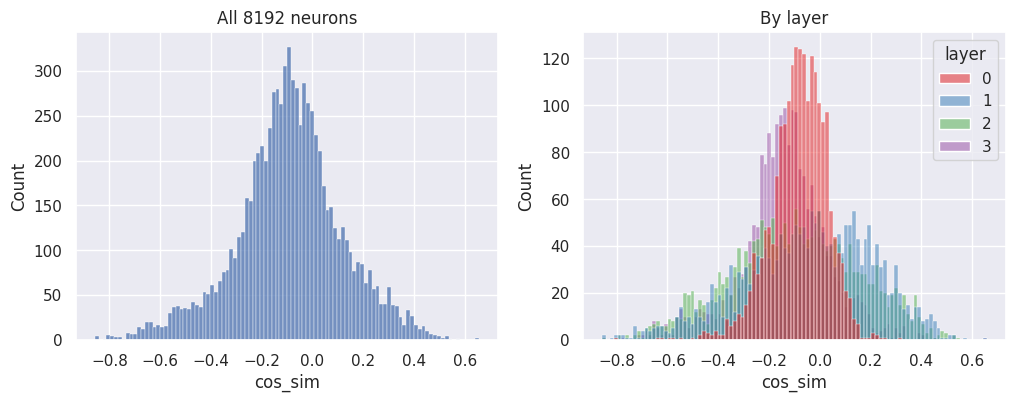

In [7]:
# Cosine similarity histogram
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df, x="cos_sim", bins=100, ax=axes[0])
sns.histplot(df, x="cos_sim", hue="layer", bins=100, palette="Set1", ax=axes[1])
axes[0].set_title(f"All {model.cfg.n_layers * model.cfg.d_mlp} neurons")
axes[1].set_title("By layer");

In [8]:
# # By layer histogram of cosine similarities, using plotly
# px.histogram(
#     df, x="cos_sim", color="layer",
#     barmode="overlay", marginal="box", nbins=80,
#     height=600,
# )

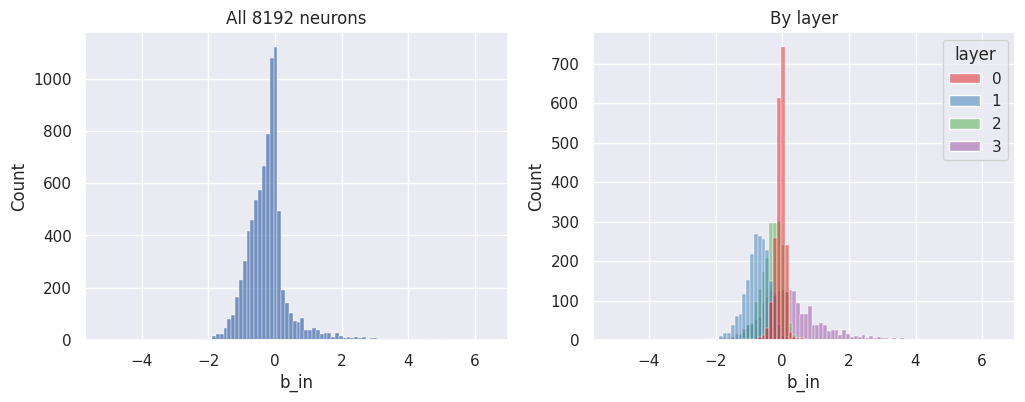

In [9]:
# b_in histogram
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df, x="b_in", bins=100, ax=axes[0])
sns.histplot(df, x="b_in", hue="layer", bins=100, palette="Set1", ax=axes[1])
axes[0].set_title(f"All {model.cfg.n_layers * model.cfg.d_mlp} neurons")
axes[1].set_title("By layer");

In [10]:
# # By layer histogram of neuron biases, using plotly
# px.histogram(
#     df, x="b_in", color="layer",
#     barmode="overlay", marginal="box", nbins=80,
#     height=600,
# )

In [11]:
df.sort_values("b_in", ascending=False).head(40)

,cos_sim,dot_prod,W_in_norm,W_out_norm,b_in,layer,neuron_index
6977,-0.064700,-0.236253,1.581494,2.308897,6.415825,3,833
7593,-0.051467,-0.214834,1.670607,2.498614,5.872520,3,1449
8076,-0.283853,-0.951358,1.375419,2.436778,5.792603,3,1932
6270,-0.388581,-1.063200,1.229713,2.224997,5.453947,3,126
7120,-0.135663,-0.419714,1.355089,2.283095,5.138247,3,976
8095,0.128103,0.463989,1.586281,2.283320,5.124976,3,1951
6260,-0.351284,-1.598141,1.647047,2.762170,4.986484,3,116
7763,-0.493297,-1.196804,1.115038,2.175828,4.950627,3,1619
8168,-0.459383,-1.197205,1.213549,2.147513,4.780376,3,2024
6693,0.104585,0.507831,2.378684,2.041337,4.737179,3,549
